In [1]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

Anotaciones:
Desde el lado de Estadistica querriamos ver que tan bueno se aproxima a una gaussiana. Desde ML que tan bien generaliza

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [3]:
data = pd.read_csv('data/alturas-pesos-mils-train.csv')[:100]

In [4]:
test = pd.read_csv('data/alturas-pesos-mils-test.csv')

In [5]:
from BiVariateJoint import BiVariateJoint

In [6]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values

In [7]:
from BiVariateJoint import get_class_prob

In [8]:
#step = 4 # 8000 ejemplos
step = 16 # 100 ejemplos
maxs = np.round(data[['Peso','Altura']].values.max(axis = 0))
mins = np.round(data[['Peso','Altura']].values.min(axis = 0))

joint_hombres = BiVariateJoint(data_hombres, 
                               step_X = step, 
                               step_Y = step,
                               mins = mins, 
                               maxs = maxs
                              )
joint_mujeres = BiVariateJoint(data_mujeres, 
                               step_X = step, 
                               step_Y = step,
                               mins = mins, 
                               maxs = maxs)

# Bayes

## Calculo a posteriori

\begin{equation}
P(Hombre | X_1, X_2) = \frac{P(X_1,X_2 | Hombre) P(Hombre)}{P(X_1,X_2)} \\
\end{equation}


In [9]:
def get_class_prob(x1_data, x2_data, joint_class_1, joint_class_2):
    prior_class_1 = joint_class_1.N/ (joint_class_1.N + joint_class_2.N)
    prior_class_2 = joint_class_2.N/ (joint_class_1.N + joint_class_2.N)
    likelihood_class_1 = joint_class_1.get_prob(x1_data, x2_data)
    likelihood_class_2 = joint_class_2.get_prob(x1_data, x2_data)
    total = likelihood_class_1*prior_class_1 + prior_class_2*likelihood_class_2
    # Evita division por cero
    total[total==0] = 1
    p_class_1 = prior_class_1*likelihood_class_1/total
    p_class_2 = prior_class_2*likelihood_class_2/total
    # Las indeterminadas en 0.5
    p_class_1[total==1] = 0.5
    p_class_2[total==1] = 0.5
    return p_class_1, p_class_2

In [10]:
p_class_1, p_class_2 = get_class_prob(data['Peso'].values, data['Altura'].values, joint_hombres, joint_mujeres)
acc_train_bayes = ((p_class_1>p_class_2) == (data['Genero'].values == 'Hombre')).sum()/len(data)
print(acc_train_bayes)

0.86


In [11]:
p_class_1, p_class_2 = get_class_prob(test['Peso'].values, test['Altura'].values, joint_hombres, joint_mujeres)
acc_cv_bayes = ((p_class_1>p_class_2) == (test['Genero'].values == 'Hombre')).sum()/len(test)
print(acc_cv_bayes)

0.8675


## Naive Bayes (Supongo independencia)

In [12]:
step = 8
maxs = np.round(data[['Peso','Altura']].values.max(axis = 0))
mins = np.round(data[['Peso','Altura']].values.min(axis = 0))

joint_hombres = BiVariateJoint(data_hombres, 
                               step_X = step, 
                               step_Y = step,
                               mins = mins, 
                               maxs = maxs
                              )
joint_mujeres = BiVariateJoint(data_mujeres, 
                               step_X = step, 
                               step_Y = step,
                               mins = mins, 
                               maxs = maxs)

In [13]:
marg_pesos_hombres,  marg_alturas_hombres = joint_hombres.get_Marginals()
marg_pesos_mujeres,  marg_alturas_mujeres = joint_mujeres.get_Marginals()

In [14]:
marg_pesos_hombres_rep, marg_alturas_hombres_rep = np.meshgrid(marg_pesos_hombres, marg_alturas_hombres)
marg_pesos_mujeres_rep, marg_alturas_mujeres_rep = np.meshgrid(marg_pesos_mujeres, marg_alturas_mujeres)

In [15]:
likelihood_indep_class_1 = (marg_pesos_hombres_rep*marg_alturas_hombres_rep).T
likelihood_indep_class_2 = (marg_pesos_mujeres_rep*marg_alturas_mujeres_rep).T

In [16]:
from BiVariateJoint import get_class_prob_naive

In [17]:
p_class_1, p_class_2 = get_class_prob_naive(data['Peso'].values, 
                                            data['Altura'].values, 
                                            joint_hombres, 
                                            joint_mujeres, 
                                           likelihood_indep_class_1,
                                           likelihood_indep_class_2)
acc_train_nbayes = ((p_class_1>p_class_2) == (data['Genero'].values == 'Hombre')).sum()/len(data)
print(acc_train_nbayes)

0.85


In [18]:
p_class_1, p_class_2 = get_class_prob_naive(test['Peso'].values, 
                                            test['Altura'].values,
                                            joint_hombres, 
                                            joint_mujeres, 
                                           likelihood_indep_class_1,
                                           likelihood_indep_class_2
                                           )
acc_cv_nbayes = ((p_class_1>p_class_2) == (test['Genero'].values == 'Hombre')).sum()/len(test)
print(acc_cv_nbayes)

0.858


Con 8000 ejemplos

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Histogram - step 4|Bayes|0.91|0.92|
|Histogram - step 8|Naive Bayes|0.90|0.90

Con 100 ejemplos

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Histogram - step 16|Bayes|0.86|0.87|
|Histogram - step 8|Naive Bayes|0.85|0.86


## Las clases en el plano

In [22]:
X, Y = np.meshgrid(joint_hombres.X, joint_hombres.Y)
Z = np.zeros(X.shape)
Z_nb = np.zeros(X.shape)
for i in range(X.shape[0]):
    Z[i] = get_class_prob(X[i], Y[i], 
                          joint_hombres, 
                          joint_mujeres)[0]
    Z_nb[i] = get_class_prob_naive(X[i], Y[i], joint_hombres, joint_mujeres, likelihood_indep_class_1,
                                           likelihood_indep_class_2)[0]

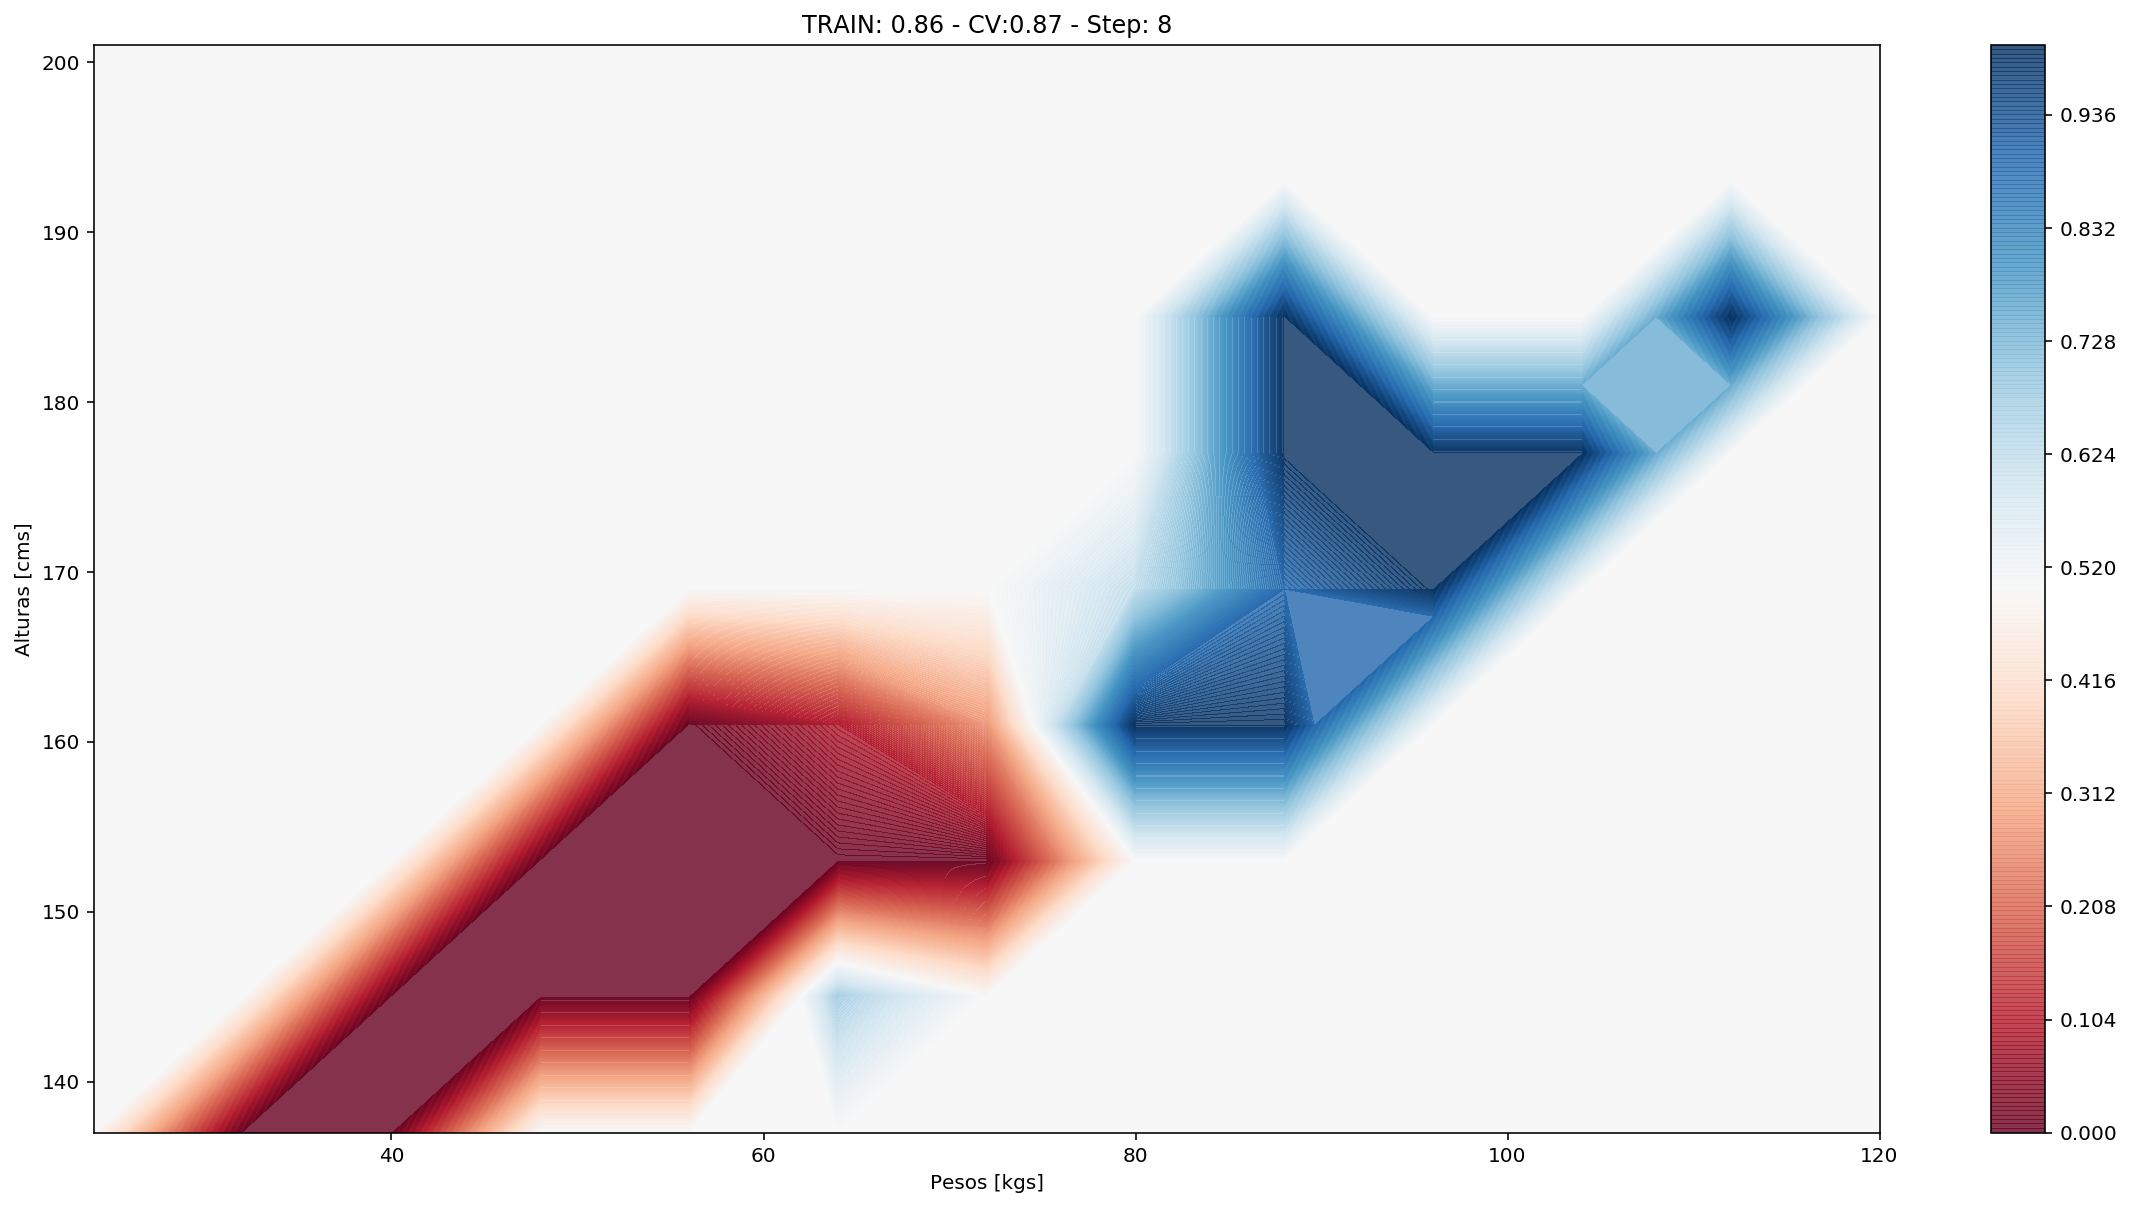

In [23]:
#%matplotlib qt
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
ax.set_title('TRAIN: ' + str(np.round(acc_train_bayes*100)/100) + ' - CV:' + str(np.round(acc_cv_bayes*100)/100) +' - Step: '+str(step))
ax.set_xlabel('Pesos [kgs]')
ax.set_ylabel('Alturas [cms]')
plt.show()

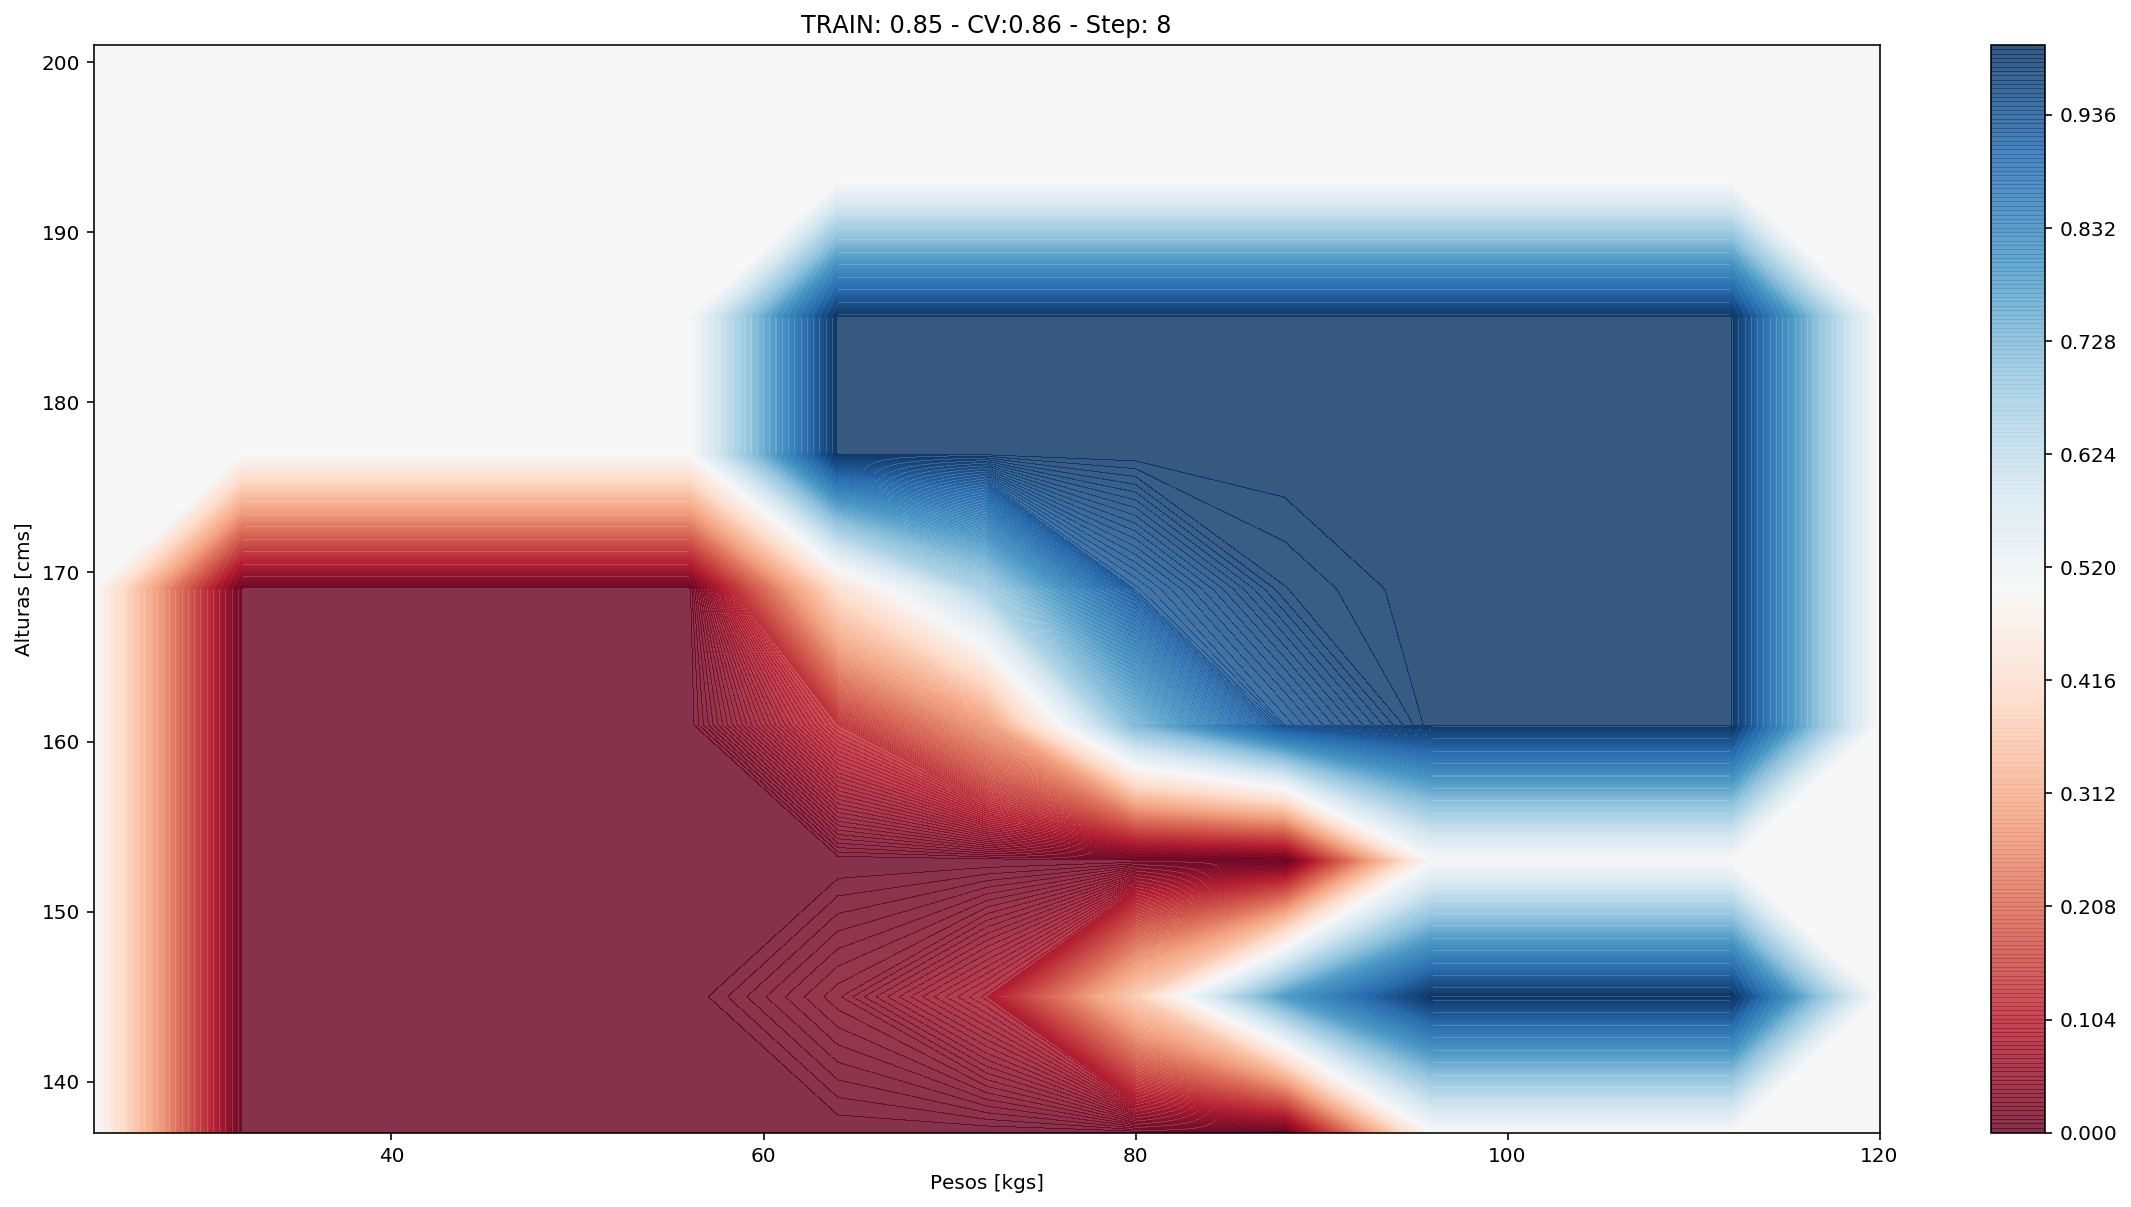

In [24]:
#%matplotlib qt
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cf = ax.contourf(X, Y, Z_nb, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
ax.set_title('TRAIN: ' + str(np.round(acc_train_nbayes*100)/100) + ' - CV:' + str(np.round(acc_cv_nbayes*100)/100) +' - Step: '+str(step))
ax.set_xlabel('Pesos [kgs]')
ax.set_ylabel('Alturas [cms]')
plt.show()

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Histogram - step 0.25|Bayes|0.97|0.68
|Histogram - step 0.25|Naive Bayes|0.89|0.88
|Histogram - step 0.5|Bayes|0.94|0.82
|Histogram - step 0.5|Naive Bayes|0.89|0.88
|Histogram - step 1|Bayes|0.92|0.90
|Histogram - step 1|Naive Bayes|0.89|0.88
|Histogram - step 4|Bayes|0.91|0.92| No generaliza por afuera de la zona de los puntos
|Histogram - step 4|Naive Bayes|0.89|0.88
|Histogram - step 8|Bayes|0.90|0.90
|Histogram - step 8|Naive Bayes|0.87|0.86
|Gaussian|Bayes|0.92|0.92|
|Gaussian|Naive Bayes|0.89|0.89|
|Regresion Logística|-|0.92|0.92|